In [33]:
import torch
import torch.nn.init
import numpy as np
import os
import random
import matplotlib.pyplot as plt


device = None
if torch.backends.mps.is_available():
    device = torch.device('mps')
elif torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

# 일정한 실험을 위해 랜덤 시드 고정
seed = 777
torch.cuda.manual_seed(seed)
torch.cuda.manual_seed_all(seed) 
random.seed(seed)
os.environ['PYTHONHASHSEED'] = str(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

print('Current Device : ' + str(device))

# MNIST 데이터셋 고정
import os
import torchvision.transforms as transforms # MNIST 데이터를 텐서 형태로 바꾸기 위해
import torchvision.datasets as dsets # 이 안에 MNIST 있다

if os.path.exists('MNIST'):
    print('There is MNIST data.')
    train_raw = dsets.MNIST(root=str(os.getcwd()), train=True, transform=transforms.ToTensor(), download=False)
    test_raw = dsets.MNIST(root=str(os.getcwd()), train=False, transform=transforms.ToTensor(), download=False)
    # train_raw = dsets.MNIST(root=str(os.getcwd()), train=True, download=False)
    # test_raw = dsets.MNIST(root=str(os.getcwd()), train=False, download=False)
else: # MNIST 데이터 다운로드
    print('There is no MNIST data.')
    train_raw = dsets.MNIST(root=str(os.getcwd()), train=True, transform=transforms.ToTensor(), download=True)
    test_raw = dsets.MNIST(root=str(os.getcwd()), train=False, transform=transforms.ToTensor(), download=True)

print(train_raw)
print(test_raw)

# MNIST 데이터셋을 원하는 레벨로 양자화 시켜 새로운 데이터셋을 만든다.
from torch.utils.data import Dataset

def quantize_tensor(tensor:torch.Tensor, levels:int) -> torch.Tensor:
    min_value = tensor.min()
    max_value = tensor.max()
    quantized_tensor = tensor.clone()
    quantized_tensor.sub_(min_value).div_(max_value - min_value + 1e-5).mul_(levels - 1).round_().div_(levels - 1).mul_(max_value - min_value + 1e-5).add_(min_value)
    return quantized_tensor

class Customdataset(Dataset):
    def __init__(self, dataset:dsets.MNIST, quantization_level = 10) -> None:
        super(Customdataset, self).__init__()
        self.origin_dataset = dataset
        self.quantization_level = quantization_level
        return None

    def __len__(self):
        return len(self.origin_dataset) # 데이터셋 크기는 양자화 해도 그대로.

    def __getitem__(self, idx:int) -> tuple[torch.Tensor, torch.Tensor]:
        data, label = self.origin_dataset[idx]
        modified_data = quantize_tensor(data, self.quantization_level)
        return modified_data, label

# 데이터셋 양자화 레벨 2로 조정 및 데이터로더 생성
BATCH_SIZE = 100
train_custom = Customdataset(train_raw, quantization_level=2)
test_custom = Customdataset(test_raw, quantization_level=2)
# train_custom = train_raw
# test_custom = test_raw
train_loader = torch.utils.data.DataLoader(dataset=train_custom, batch_size=BATCH_SIZE, shuffle=True, drop_last=True)
test_loader = torch.utils.data.DataLoader(dataset=test_custom, batch_size=BATCH_SIZE, shuffle=True, drop_last=True)

# 데이터 로더 동작 확인
for x,y in train_loader:
    print('입력 데이터 형태: ', x.shape)
    print('정답 데이터 형태: ', y.shape)
    break

import torch.nn as nn
from torchinfo import summary

class CRFC(nn.Module):
    def __init__(self) -> None:
        super().__init__()
        IMG_WIDTH = 28
        COL_CH = 2
        ROW_CH = 2
        self.col1 = nn.Conv2d(in_channels=1, out_channels=1, kernel_size=(IMG_WIDTH,1), bias=False) # MINST : 흑백이미지 -> 채널=1
        self.col2 = nn.Conv2d(in_channels=1, out_channels=1, kernel_size=(IMG_WIDTH,1), bias=False)
        self.row1 = nn.Conv2d(in_channels=1, out_channels=1, kernel_size=(1,IMG_WIDTH), bias=False)
        self.row2 = nn.Conv2d(in_channels=1, out_channels=1, kernel_size=(1,IMG_WIDTH), bias=False)
        self.relu = nn.ReLU()
        self.fc1 = nn.Linear(IMG_WIDTH, 10, bias=False) # MNIST 답 선택지 개수=10
        self.fc2 = nn.Linear(IMG_WIDTH, 10, bias=False)
        self.fc3 = nn.Linear(IMG_WIDTH, 10, bias=False)
        self.fc4 = nn.Linear(IMG_WIDTH, 10, bias=False)
        self.softmax = nn.Softmax(dim=1)

    def forward(self, input:torch.Tensor, quantize=False) -> torch.Tensor:
        h1 = self.col1(input).squeeze() # (BATCH_SIZE, COL_CH, 1, IMG_WIDTH) 에서 1인 차원 제거 
        h1 = self.relu(h1)
        h1 = self.fc1(h1) # torch.Size([[BATCH_SIZE, COL_CH, 10])

        h2 = self.col2(input).squeeze()
        h2 = self.relu(h2)
        h2 = self.fc2(h2)

        h3 = self.row1(input).squeeze()
        h3 = self.relu(h3)
        h3 = self.fc3(h3)

        h4 = self.row2(input).squeeze()
        h4 = self.relu(h4)
        h4 = self.fc4(h4)

        h5 = h1 + h2 + h3 + h4
        output = self.softmax(h5)
        return output
    
    def forward_with_quantization(self, input:torch.Tensor) -> torch.Tensor:
        h1 = self.col1(input).squeeze() # (BATCH_SIZE, COL_CH, 1, IMG_WIDTH) 에서 1인 차원 제거 
        h1 = self.relu(h1)
        h1 = quantize_tensor(h1,10)
        h1 = self.fc1(h1) # torch.Size([[BATCH_SIZE, COL_CH, 10])

        h2 = self.col2(input).squeeze()
        h2 = self.relu(h2)
        h2 = quantize_tensor(h2,10)
        h2 = self.fc2(h2)

        h3 = self.row1(input).squeeze()
        h3 = self.relu(h3)
        h3 = quantize_tensor(h3,10)
        h3 = self.fc3(h3)

        h4 = self.row2(input).squeeze()
        h4 = self.relu(h4)
        h4 = quantize_tensor(h4,10)
        h4 = self.fc4(h4)

        h5 = h1 + h2 + h3 + h4
        output = self.softmax(h5)
        return output
    
    def compute_hidden_state(self, input:torch.Tensor) -> tuple[torch.Tensor,torch.Tensor,torch.Tensor,torch.Tensor]:
        h1 = self.col1(input).squeeze() # (BATCH_SIZE, COL_CH, 1, IMG_WIDTH) 에서 1인 차원 제거 
        h1 = self.relu(h1)

        h2 = self.col2(input).squeeze()
        h2 = self.relu(h2)

        h3 = self.row1(input).squeeze()
        h3 = self.relu(h3)

        h4 = self.row2(input).squeeze()
        h4 = self.relu(h4)
        return h1, h2, h3, h4


Current Device : mps
There is MNIST data.
Dataset MNIST
    Number of datapoints: 60000
    Root location: /Users/ljs/NODE
    Split: Train
    StandardTransform
Transform: ToTensor()
Dataset MNIST
    Number of datapoints: 10000
    Root location: /Users/ljs/NODE
    Split: Test
    StandardTransform
Transform: ToTensor()
입력 데이터 형태:  torch.Size([100, 1, 28, 28])
정답 데이터 형태:  torch.Size([100])


In [34]:
model = CRFC()
model.load_state_dict(torch.load('model_0202.pth'))

<All keys matched successfully>

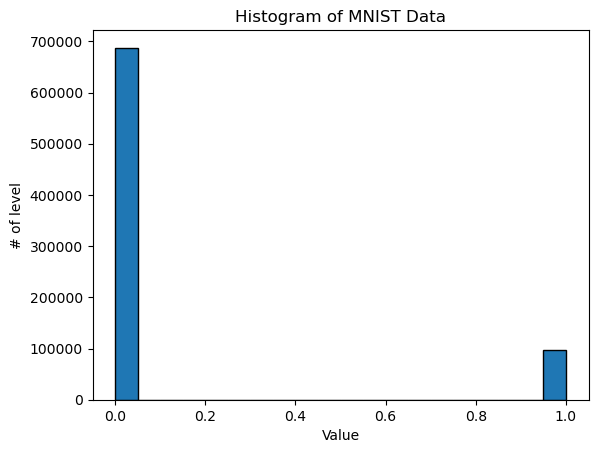

In [35]:
# 데이터에서 어떤 레벨의 값들이 많은지 확인
import numpy as np
import matplotlib.pyplot as plt

temp = np.zeros(1)
for idx, (data,label) in enumerate(test_custom):
    temp = np.append(temp, data.view(-1).numpy())
    if idx == 1000: break # 1000개만. 너무 많으면 동작 멈춰버리는듯?

plt.hist(temp, bins=20, edgecolor='black') # Plot the histogram with 20 bins and black edges
plt.title('Histogram of MNIST Data') # Add title to the plot
plt.xlabel('Value') # Label the x-axis
plt.ylabel('# of level') # Label the y-axis
plt.show() # Display the plot
# 100개 데이터에 대해 확인해보았더니, 0,1 레벨 값이 제일 많더라.
# 2개 레벨로 줄여버려야지.

(28,)
(28,)
(28,)
(28,)
(280,)
(280,)
(280,)
(280,)


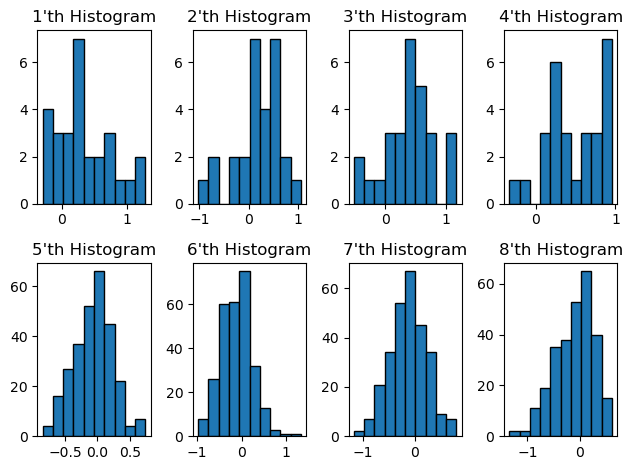

In [36]:
#파라미터들이 어떤 weight에 얼마나 분포하고 있나를 확인 
param_arr = []
for idx, param in enumerate(model.cpu().parameters()):
    param = param.detach().numpy().reshape(-1)
    print(param.shape)
    param_arr.append(param)

for idx, params in enumerate(param_arr):
    plt.subplot(2,4,idx+1)
    plt.hist(params, bins=10, edgecolor='black')
    plt.title(str(idx+1)+'\'th Histogram')
plt.tight_layout()
plt.show()

In [37]:
# 테스트 MNIST 데이터에 대해, hidden state 값들의 histogram
model.eval()
hidden_state_arr = np.ndarray(0)
with torch.no_grad():
    for image, label in test_loader:
        h1,h2,h3,h4 = model.compute_hidden_state(image)
        hidden_state_arr = np.append(hidden_state_arr, h1.numpy())
        hidden_state_arr = np.append(hidden_state_arr, h2.numpy())
        hidden_state_arr = np.append(hidden_state_arr, h3.numpy())
        hidden_state_arr = np.append(hidden_state_arr, h4.numpy())

테스트셋에 대해 히든 스테이트 개수 :  (1120000,)


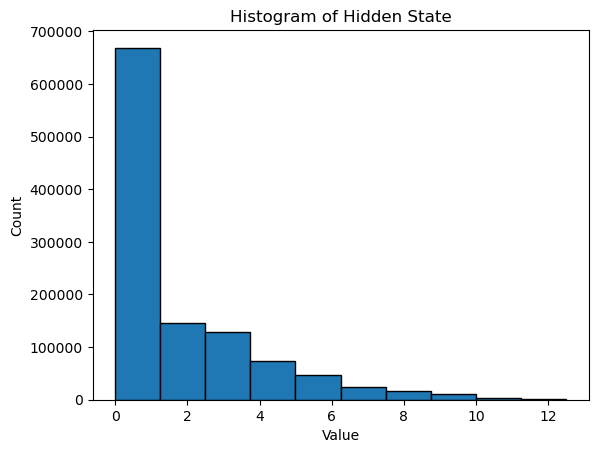

In [38]:
# 히든스테이트에서 값들이 몇개씩 분포하는지 보자
print('테스트셋에 대해 히든 스테이트 개수 : ', hidden_state_arr.shape)

plt.hist(hidden_state_arr, bins=10, edgecolor='black') # Plot the histogram with 20 bins and black edges
plt.title('Histogram of Hidden State') # Add title to the plot
plt.xlabel('Value') # Label the x-axis
plt.ylabel('Count') # Label the y-axis
plt.show() # Display the plot


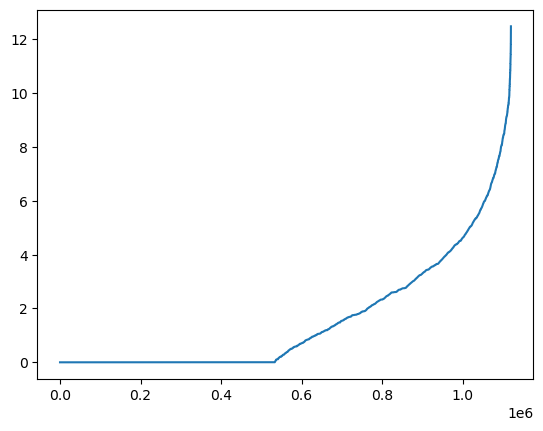

In [39]:
# 오름차순으로 정렬해서 그래프로
hidden_state_arr_sorted = np.sort(hidden_state_arr)
plt.plot(range(len(hidden_state_arr_sorted)), hidden_state_arr_sorted)
plt.show()

In [40]:
# hidden state 값을 양자화 시켜서 정확도 평가
model.eval()
accuracy = 0.0
total = 0.0
with torch.no_grad():
    for image, label in test_loader:
        outputs = model.forward_with_quantization(image)
        _, predicted = torch.max(outputs.data, 1)
        total += label.size(0)
        accuracy += (predicted == label).sum().item()
accuracy = (100 * accuracy / total)
print('hidden state 양자화 했을 때 정확도 : {:.2f}'.format(accuracy))


hidden state 양자화 했을 때 정확도 : 90.01
